# TIDY NOTEBOOK TO MAKE ALL FIGURES FOR PAPER

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
# Initialize models

"""ReLU + x model with Identity embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    name = "ReluPlusX_NoEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)


"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [3]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.50

In [4]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.09928914904594421,
 0.03588598594069481,
 0.03600328788161278,
 0.036016929894685745,
 0.03609831631183624,
 0.03617118299007416,
 0.03570341691374779,
 0.03562192991375923,
 0.03575350344181061,
 0.035297051072120667,
 0.03570125997066498]

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

X.shape =  torch.Size([100, 100, 100])
Y.shape =  torch.Size([100, 100, 100])


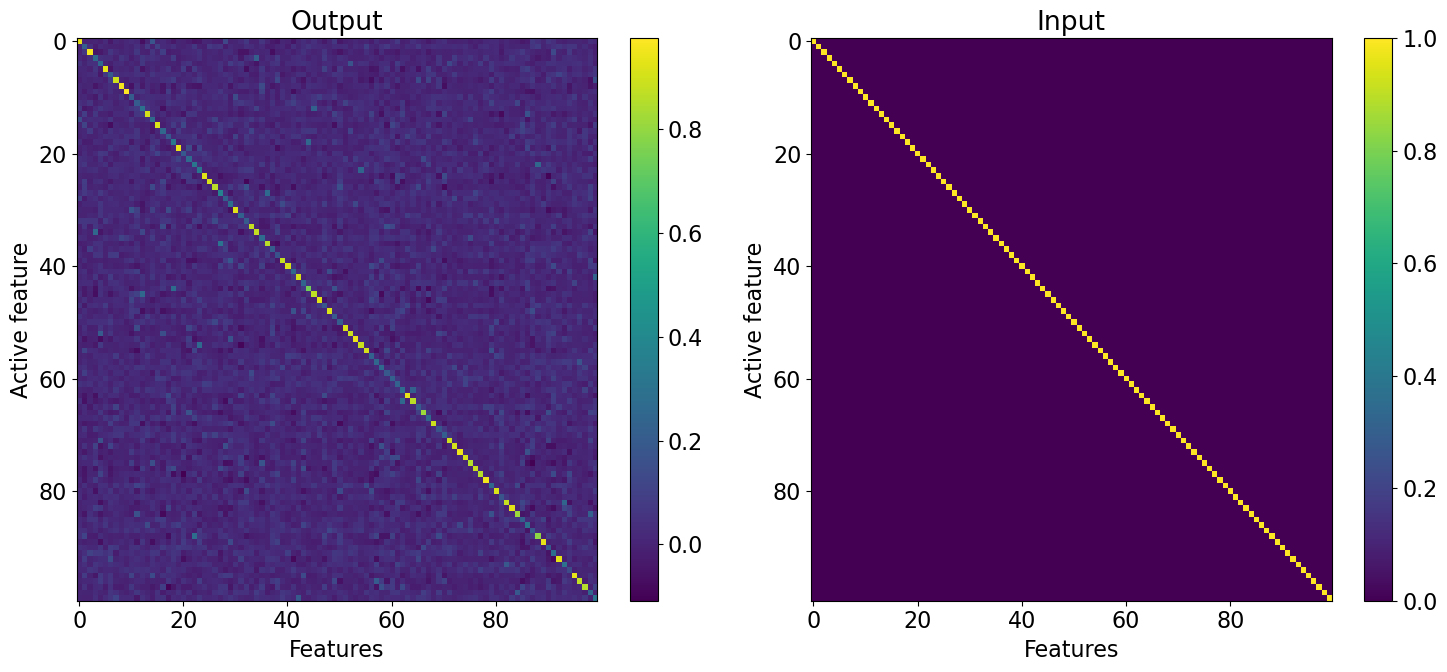

[[ 1.9361231e+00 -6.4168163e-03 -6.4253444e-03 ... -3.1987990e-03
   4.0271595e-02  2.0104868e-02]
 [-5.5708904e-03  1.2184831e+00  3.8929172e-02 ...  3.2836009e-02
  -5.9017288e-03 -1.7654778e-02]
 [-2.1036407e-03  5.8820270e-02  1.9583166e+00 ...  2.0044558e-03
   2.7454475e-02 -1.2245389e-02]
 ...
 [-1.2126253e-02  4.6657044e-02 -1.2276874e-02 ...  1.8550153e+00
  -8.4479284e-03  1.0443895e-01]
 [ 8.0526089e-03  4.1280980e-03  2.8389152e-03 ... -1.1797049e-02
   1.2423433e+00 -5.7317158e-03]
 [ 5.1799947e-03 -2.8507126e-04 -1.8939227e-03 ...  6.6476785e-02
  -1.4660885e-02  1.3034565e+00]]


In [5]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr = []    # outputs when only represented features (diagonal ones) are active
outputs_unrepr = []  # outputs when only unrepresented features (diagonal ones) are active
outputs_repr_norm = []    # outputs when only represented features (diagonal ones) are active
outputs_unrepr_norm = [] 
active_counts = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        active_counts.append([k] * n_features)
        outputs_repr.append(y_repr.cpu().numpy())
        outputs_repr_norm.append(norm_y_repr.cpu().numpy())

# --- Flatten the results for plotting ---
flat_counts = np.concatenate([np.array(o).flatten() for o in active_counts])
flat_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm])

# --- Plot the outputs vs. number of active features ---
plt.figure(figsize=(10, 7))
plt.scatter(flat_norm_outputs_repr, flat_counts, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts, cmap='magma', fill=False, thresh=0.05, levels=20, bw_adjust=1, label='bw_adjust=0.5') 
plt.xlabel("Model Output")
plt.ylabel("Number of Active Represented Features")
plt.title("Model Output vs. Number of Active Represented Features")
plt.show()


active_counts = []
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_unrepr = y_unrepr - x_unrepr
        active_counts.append([k] * n_features)
        outputs_unrepr.append(y_unrepr.cpu().numpy())
        outputs_unrepr_norm.append(norm_y_unrepr.cpu().numpy())

# --- Flatten the results for plotting ---
flat_counts = np.concatenate([np.array(o).flatten() for o in active_counts])
flat_outputs_unrepr = np.concatenate([o.flatten() for o in outputs_unrepr])
flat_norm_outputs_unrepr = np.concatenate([o.flatten() for o in outputs_unrepr_norm])

# --- Plot the outputs vs. number of active features ---
plt.figure(figsize=(10, 7))
plt.scatter(flat_norm_outputs_unrepr, flat_counts, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unrepr, y=flat_counts, cmap='magma', fill=False, thresh=0.05, levels=20, bw_adjust=1, label='bw_adjust=0.5')
plt.xlabel("Model Output")
plt.ylabel("Number of Active Unrepresented Features")
plt.title("Model Output vs. Number of Active Unrepresented Features")
plt.show()


Represented indices (diagonal): [ 0  2  5  7  8  9 13 15 19 24 25 26 30 33 34 36 39 40 42 44 45 46 48 51
 52 53 54 55 63 64 66 68 71 72 73 74 75 76 77 78 80 82 83 84 88 89 92 95
 96 97]
Unrepresented indices (diagonal): [ 1  3  4  6 10 11 12 14 16 17 18 20 21 22 23 27 28 29 31 32 35 37 38 41
 43 47 49 50 56 57 58 59 60 61 62 65 67 69 70 79 81 85 86 87 90 91 93 94
 98 99]


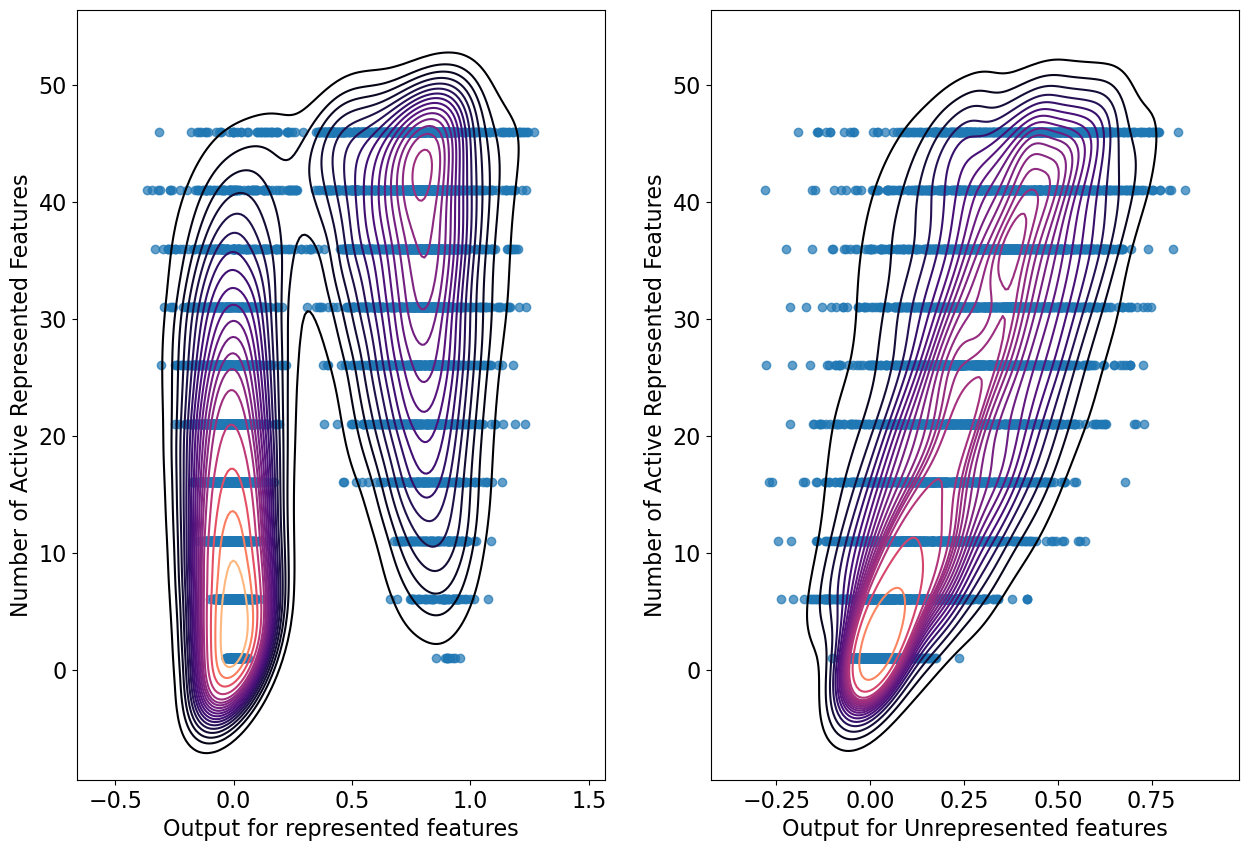

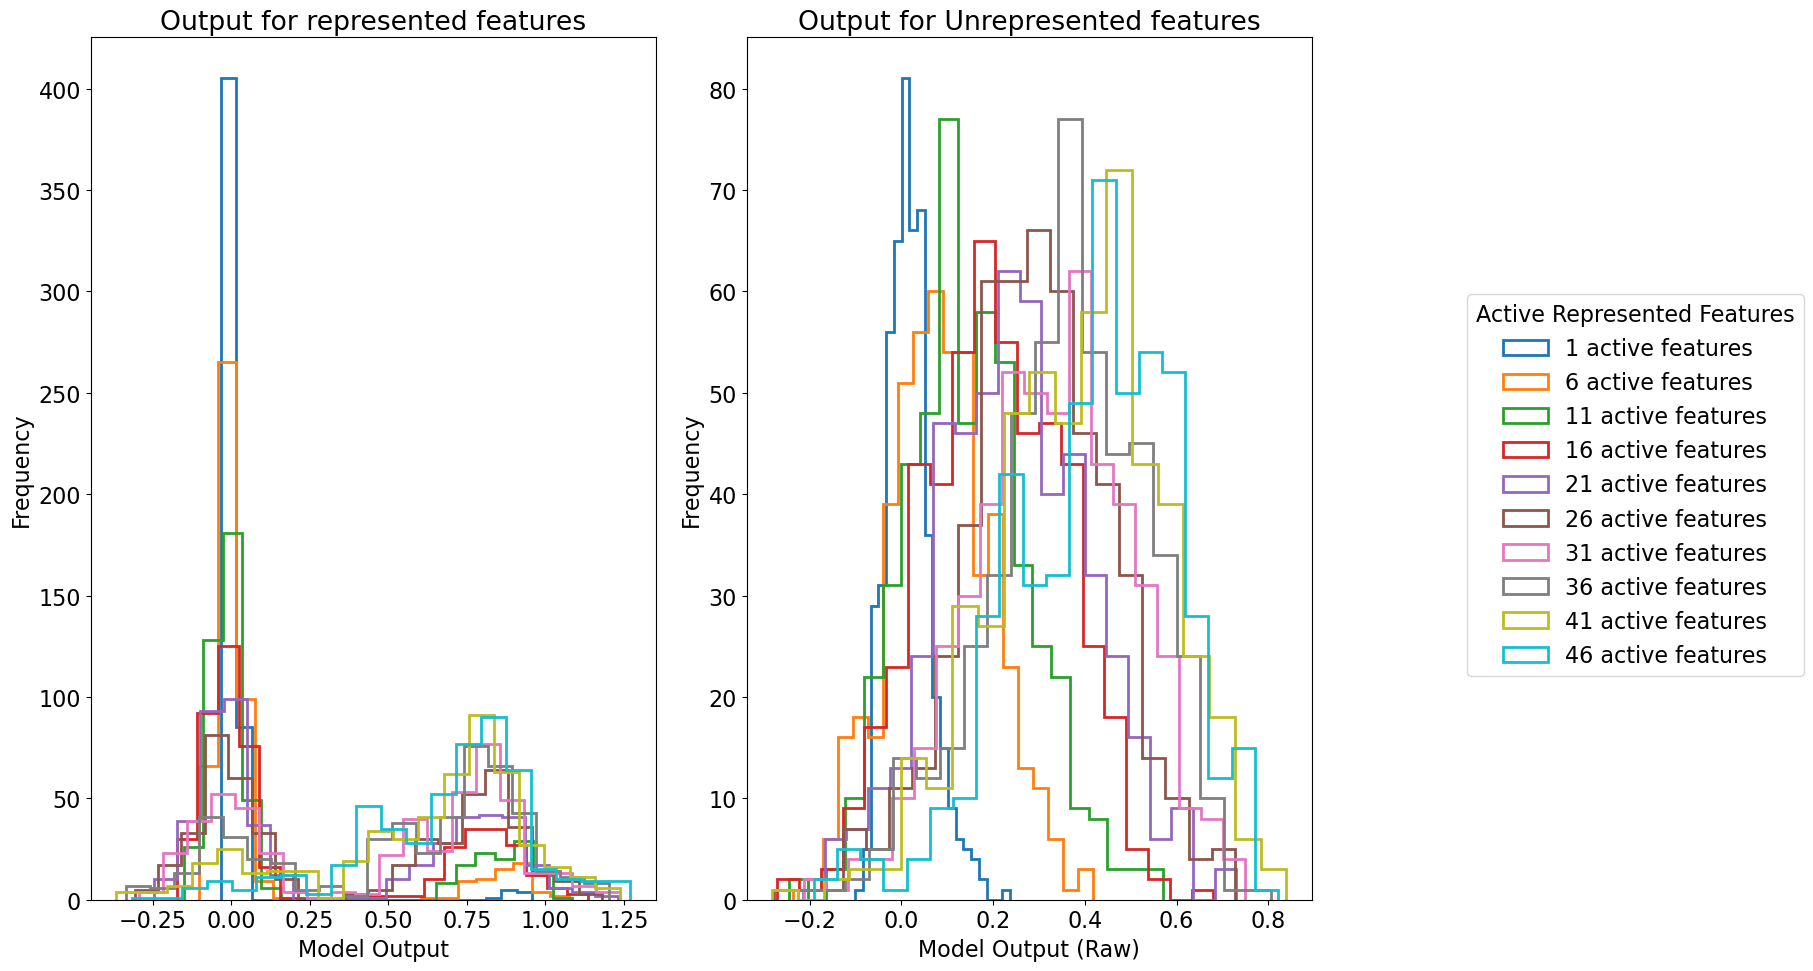

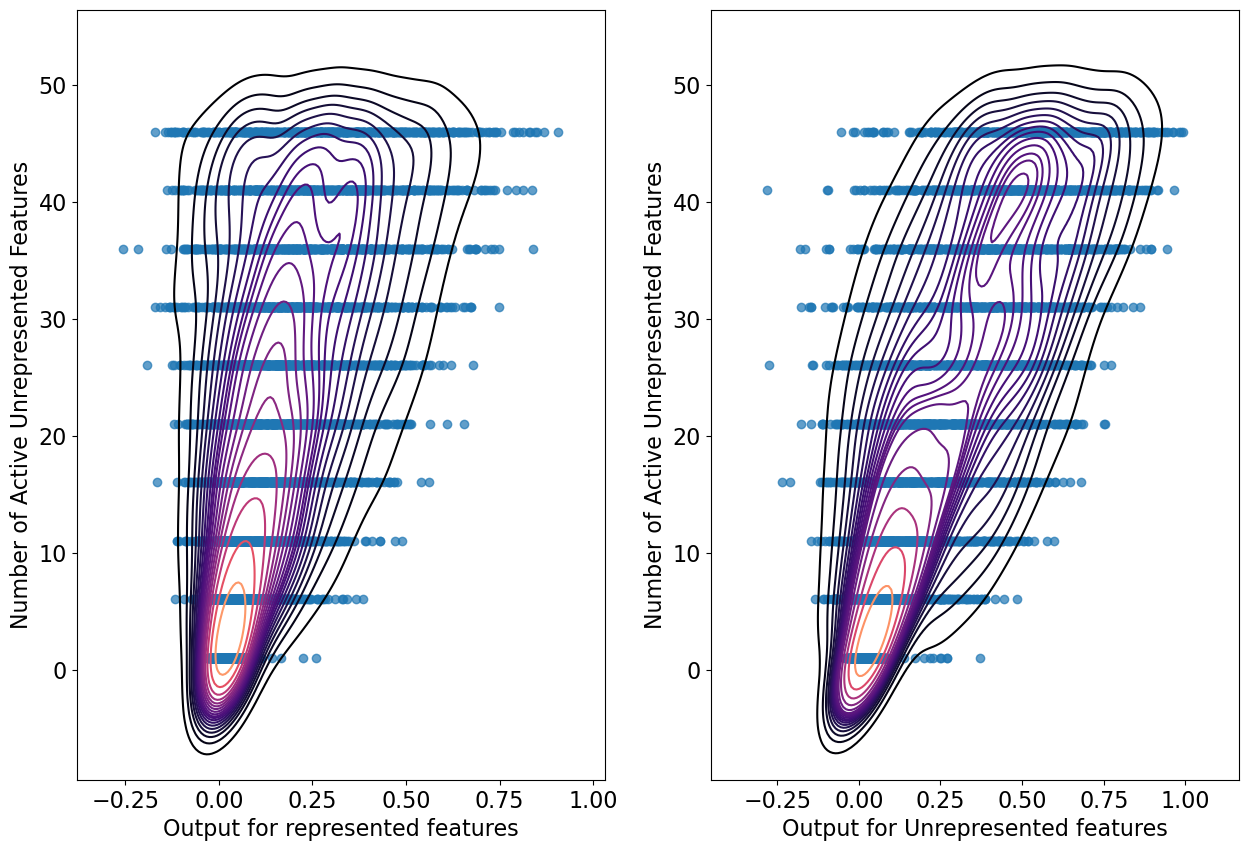

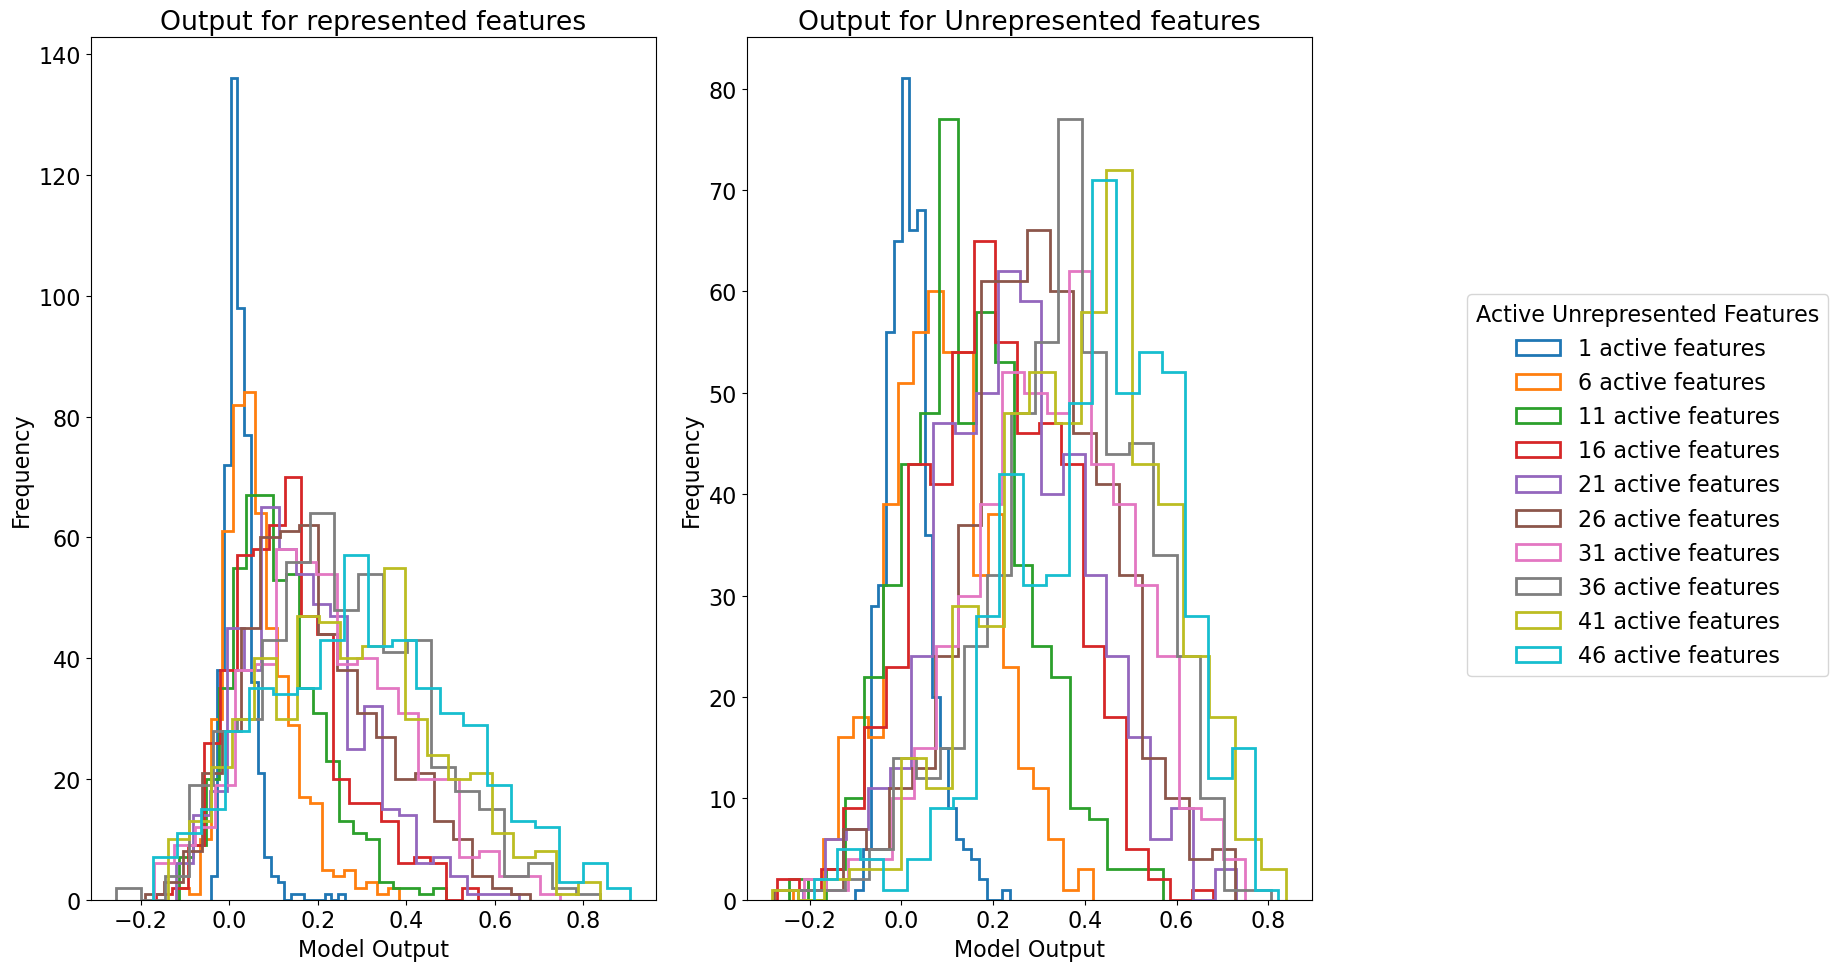

In [12]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr_rep = []    # outputs when only represented features (diagonal ones) are active
outputs_repr_norm_rep = [] 
outputs_repr_unrep = [] 
outputs_repr_norm_unrep = [] 
active_counts_rep = []
active_counts_unrep = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_repr_norm_rep.append(norm_y_np[idx_repr])
        outputs_repr_norm_unrep.append(norm_y_np[idx_unrepr])

# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm_rep])
flat_norm_outputs_unre = np.concatenate([o.flatten() for o in outputs_repr_norm_unrep])

# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_repr, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Represented Features")

ax2.scatter(flat_norm_outputs_unre, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unre, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Represented Features")

#plt.title("Model Output vs. Number of Active Represented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_repr[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output (Raw)")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Represented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

active_counts_rep = []
active_counts_unrep = []
outputs_unrepr_rep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_rep = [] 
outputs_unrepr_unrep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_unrep = [] 
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_unrepr - x_unrepr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_unrepr_norm_rep.append(norm_y_np[idx_repr])
        outputs_unrepr_norm_unrep.append(norm_y_np[idx_unrepr])
        
# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_un = np.concatenate([o.flatten() for o in outputs_unrepr_norm_unrep])
flat_norm_outputs_re = np.concatenate([o.flatten() for o in outputs_unrepr_norm_rep])

# --- Plot the outputs vs. number of active features ---
# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_re, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_re, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Unrepresented Features")

ax2.scatter(flat_norm_outputs_un, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_un, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Unrepresented Features")

#plt.title("Model Output vs. Number of Active Unepresented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_re[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Unrepresented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr = []    # outputs when only represented features (diagonal ones) are active
outputs_unrepr = []  # outputs when only unrepresented features (diagonal ones) are active
outputs_repr_norm = []    # outputs when only represented features (diagonal ones) are active
outputs_unrepr_norm = [] 
active_counts = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        active_counts.append([k] * n_features)
        outputs_repr_rep.append(y_repr.cpu().numpy())
        outputs_repr_norm_rep.append(norm_y_repr.cpu().numpy())

# --- Flatten the results for plotting ---
flat_counts = np.concatenate([np.array(o).flatten() for o in active_counts])
flat_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm])

print('len counts = ', len(flat_counts))
print('len output = ', len(flat_norm_outputs_repr))
# --- Plot the outputs vs. number of active features ---
plt.figure(figsize=(10, 7))
plt.scatter(flat_norm_outputs_repr, flat_counts, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts, cmap='magma', fill=False, thresh=0.05, levels=20, bw_adjust=1, label='bw_adjust=0.5') 
plt.xlabel("Model Output")
plt.ylabel("Number of Active Represented Features")
plt.title("Model Output vs. Number of Active Represented Features")
plt.show()

active_counts = []
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_unrepr = y_unrepr - x_unrepr
        active_counts.append([k] * n_features)
        outputs_unrepr.append(y_unrepr.cpu().numpy())
        outputs_unrepr_norm.append(norm_y_unrepr.cpu().numpy())

# --- Flatten the results for plotting ---
flat_counts = np.concatenate([np.array(o).flatten() for o in active_counts])
flat_outputs_unrepr = np.concatenate([o.flatten() for o in outputs_unrepr])
flat_norm_outputs_unrepr = np.concatenate([o.flatten() for o in outputs_unrepr_norm])

# --- Plot the outputs vs. number of active features ---
plt.figure(figsize=(10, 7))
plt.scatter(flat_norm_outputs_unrepr, flat_counts, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unrepr, y=flat_counts, cmap='magma', fill=False, thresh=0.05, levels=20, bw_adjust=1, label='bw_adjust=0.5')
plt.xlabel("Model Output")
plt.ylabel("Number of Active Unrepresented Features")
plt.title("Model Output vs. Number of Active Unrepresented Features")
plt.show()


In [ ]:
flat_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm])

In [ ]:
"""Plot histograms if more than 1 active feature"""

input_length = 100
number_samples = 10

active_counts = []
outputs = []
normalized_outputs = []

for k in range(1, input_length + 1, 5):

    for sample in range(number_samples):
        
        # Create a 100-length input vector initialized to zeros.
        x = t.zeros(input_length, device=device)
        
        indices = t.randperm(input_length, device=device)[:k]
        x[indices] = t.empty(k, device=device).uniform_(-1, 1)
    
        # Add a batch dimension and feed the input to the model.
        with t.no_grad():
            y = model.forward(x.unsqueeze(0).unsqueeze(0))
        normalized_y = y - x
        active_counts.append([k] * input_length)  
        outputs.append(y.cpu().numpy())
        normalized_outputs.append(normalized_y.cpu().numpy())

flat_counts = [val for sublist in active_counts for val in np.atleast_1d(sublist)]
flat_outputs = np.concatenate([o.flatten() for o in outputs])
flat_norm_outputs = np.concatenate([o.flatten() for o in normalized_outputs])
print('flat_counts length = ', len(flat_counts))
print('flat_outputs length = ', len(flat_outputs))
print('active_counts length = ', len(active_counts[0]))

# Plot a scatter plot: x-axis = model output, y-axis = number of active features.
plt.figure(figsize=(10, 7))
plt.scatter(flat_outputs, flat_counts, alpha=0.7)
plt.xlabel("Model Output")
plt.ylabel("Number of Active Features")
plt.title("Model Output vs. Number of Active Features")
plt.show()

# Plot a scatter plot: x-axis = model output, y-axis = number of active features.
plt.figure(figsize=(10, 7))
plt.scatter(flat_norm_outputs, flat_counts, alpha=0.7)
plt.xlabel("Model Output")
plt.ylabel("Number of Active Features")
plt.title("Model Output vs. Number of Active Features")
plt.show()

from matplotlib.colors import LogNorm
# Plot the 2D histogram.
plt.figure(figsize=(10, 7))
# You can adjust the number of bins for both dimensions as desired.
plt.hist2d(flat_outputs, flat_counts, bins=[50, 50], cmap='viridis', norm=LogNorm())
plt.colorbar(label='Log Frequency')
plt.xlabel("Model Output Value")
plt.ylabel("Number of Active Features")
plt.title("2D Histogram: Model Output vs. Number of Active Features")
plt.show()

plt.figure(figsize=(10, 7))
# You can adjust the number of bins for both dimensions as desired.
plt.hist2d(flat_norm_outputs, flat_counts, bins=[50, 50], cmap='viridis', norm=LogNorm())
plt.colorbar(label='Log Frequency')
plt.xlabel("Model Output Value")
plt.ylabel("Number of Active Features")
plt.title("2D Histogram: Model Output vs. Number of Active Features")
plt.show()

plt.figure(figsize=(10, 7))
# You can adjust the number of bins for both dimensions as desired.
plt.scatter(flat_norm_outputs, flat_counts, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs, y=flat_counts, cmap='magma', fill=False, thresh=0.05, levels=20)
plt.xlabel("Model Output Value")
plt.ylabel("Number of Active Features")
plt.title("2D Histogram: Model Output vs. Number of Active Features")
plt.show()

In [ ]:
# Create one subplot per key in the dictionary.
keys = sorted(results.keys())
n_plots = len(keys)

fig, axs = plt.subplots(n_plots, 1, figsize=(10, 3 * n_plots), sharex=True)
if n_plots == 1:  # ensure axs is always iterable
    axs = [axs]

for ax, k in zip(axs, keys):
    # Flatten all outputs for a given active feature count `k`
    flat_outputs = np.concatenate([o.flatten() for o in results[k]])
    ax.hist(flat_outputs, bins=50, color='steelblue', alpha=0.7)
    ax.set_title(f"Histogram of outputs (k = {k} active features)")
    ax.set_ylabel("Frequency")

plt.xlabel("Model Output Value")
plt.tight_layout()
plt.show()

In [ ]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

In [ ]:
"""Plot a phase diagram of loss of training sparsity vs input sparsity performance"""

"""Choose model and specify sparsities to explore"""
model_cfg = reluPlusX_res_noEmbed_cfg

sparsities = np.array([0.1, 0.3,0.5,0.7,0.8,0.85, 0.9,0.95,0.99])

"Hyperparameters"
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
for feat_sparsity in sparsities: 

    model = Cis(model_cfg, device=device).to(device)
    n_steps = 2000 / (1-feat_sparsity)
    n_steps = n_steps.astype(int)
    logging_freq = n_steps // 10

    """Train the model at a given sparsity"""
    losses = model.train_reluPlusX(
            batch_sz,
            feat_sparsity,
            feat_importance,
            n_steps,
            lr, 
            logging_freq, 
    )

    """Test this model's performance across a range of sparsities"""
    loss_data = performance_across_sparsities(sparsities, model, loss_data, feat_sparsity)

# Show plot
fig = plot_phase_diagram (loss_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Plot training sparsity vs training steps + loss and polysemanticity"""

"Choose model, in this case only identity embedding"
model_cfg = reluPlusX_res_noEmbed_cfg

train_sparsities = np.array([0.5, 0.75, 0.90, 0.95, 0.99])
sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
steps = np.array([1000, 2000, 3000, 5000, 8000, 12000, 20000, 32000, 52000])
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# Iterate over training sparsities
loss_data = []
poly_data = []
eval_data = []
for feat_sparsity in train_sparsities:
    n_steps = 1
    """Train the model at a given sparsity"""
    model = Cis(model_cfg, device=device).to(device)
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    while n_steps <= steps[-1]:
        x, y_true = model.gen_batch_reluPlusX(batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = model.loss_fn_reluPlusX(y, y_true, feat_importance)
        
        # Update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * n_steps / (steps[-1] - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # check if the current step is an evaluation step and extract loss and polysemanticity
        if n_steps in steps:
            
            """Store loss at last training step"""
            loss_data.append({"sparsity": feat_sparsity, "n_steps": n_steps,
                          "loss": loss.item()})
            
            """Store average feature weights per neuron"""
            if model.cfg.We_and_Wu == True:
                W_feat_to_neuron = einsum(model.We, model.W1,
                                      "inst emb feat, inst neuron emb -> neuron feat")
                W_neuron_to_feat = einsum(model.W2, model.Wu,
                                      "inst emb neuron, inst feat emb -> feat neuron")
                W = einsum(W_feat_to_neuron, W_neuron_to_feat,
                           "neuron feat, feat neuron -> feat neuron")
            else:
                W = einsum(model.W1, model.W2,
                   "inst neuron feature, inst feature neuron-> neuron feature")
            W = threshold_matrix(W.squeeze(), threshold=0.001)
            features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1)
            del W
            poly_data.append({"sparsity":feat_sparsity, "n_steps": n_steps, 
                              "features_per_neuron": features_per_neuron})

            """Compute performance across sparsities"""
            eval_data = performance_across_sparsities(sparsities, model, eval_data, feat_sparsity, n_steps)
            
        # add an extra step and continue
        n_steps += 1

fig = plot_phase_diagram_training(loss_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_loss.png"
plt.savefig(filename, dpi=300)
plt.show()

fig = plot_phase_diagram_polysem(poly_data, model.cfg.name)
filename = f"/workspace/{model.cfg.name}_phase_diagram_polysem.png"
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
df_loss = pd.DataFrame(eval_data)
df_loss["featProbs"] = np.round(1 - df_loss["input_sparsity"],2)
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["input_sparsity"])

unique_A = df_loss['train_sparsity'].unique()
n_plots = len(unique_A)

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

fig, axes = plt.subplots(n_plots, 1, figsize=(10, 7 * n_plots), sharex=True)

# Ensure axes is iterable even if there's only one subplot
if n_plots == 1:
    axes = [axes]

for ax, a_val in zip(axes, unique_A):
    subset = df_loss[df_loss['train_sparsity'] == a_val]
    sns.lineplot(data=subset, x='featProbs', y='loss/1-S', hue='n_steps', ax=ax, palette='colorblind')
    ax.axhline(y=norm_loss[0], linestyle="dashed", color="black", label=r"Naive loss") 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid()
    ax.legend(loc = "best", fontsize = 12)
    ax.set_ylabel('Adjusted loss (loss / p)')
    ax.set_xlabel('Evaluation feature probability')
    ax.set_title(f"training Feature Probability = {1 - a_val:.2f}")

plt.tight_layout()
plt.show()